In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
try:  
    import ipyplot
except:
    !pip install  ipyplot
    import ipyplot

In [74]:
from multiprocess import cpu_count
from collections import defaultdict
import random
import csv
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf
import numpy as np

In [106]:
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import RandAugment
from tensorflow_similarity.architectures import EfficientNetSim
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

# s

https://www.kaggle.com/c/landmark-retrieval-2021/overview

In [35]:
IMG_SIZE = 224
CLASSES_PER_BATCH = 16  # batch size = CLASSES_PER_BATCH* 2
NUM_IMGS = 1580470
NUM_LANDMARKS = 203092
NUM_VAL_LANDMAKRS = 300
val_lmk_idxs = random.sample([i for i in range(NUM_LANDMARKS)], k=NUM_VAL_LANDMAKRS)
CPU_COUNT = cpu_count()
print("NUM CPU:", CPU_COUNT)

NUM CPU: 16


In [119]:
data_path = '../tmp/landmark-retrieval-2021/'
x_train = []
y_train = []
x_test_p = []
y_test = []
testlmk2id = {}
f = open(data_path + 'train.csv')
csvreader = csv.reader(f, )
pb = tqdm(total=1580469, desc="loading images path")
for row_id, row in enumerate(csvreader):
    
    # skip headers
    if row_id > 1:

        # compute path to img
        slug = "/".join([row[0][i] for i in range(3)])
        img_path = data_path + 'train/' + slug + '/' + row[0] + ".jpg"
    
        # add img either in validation or testing
        cidx = int(row[1])
        if cidx in val_lmk_idxs:
            y_test.append(cidx) 
            x_test_p.append(img_path) 
            testlmk2id[cidx] = len(testlmk2id)   
        else:
            y_train.append(cidx)            
            x_train.append(img_path)
        pb.update()
pb.close()

print("train size", len(x_train))
print("test size", len(x_test_p))

loading images path: 100%|██████████| 1580469/1580469 [00:08<00:00, 176964.39it/s]

train size 1577570
test size 2899


## Prepare validation

100%|██████████| 2899/2899 [00:10<00:00, 263.68it/s]



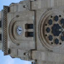
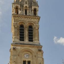
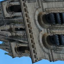
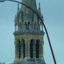
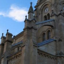
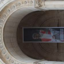
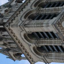
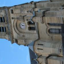
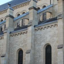
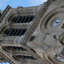
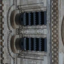
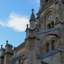
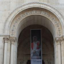
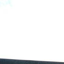
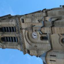
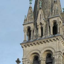
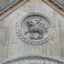
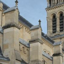
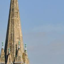
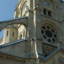
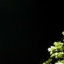
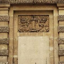
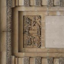
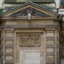
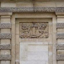
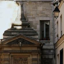
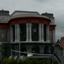
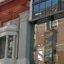
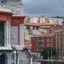
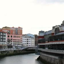


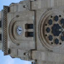
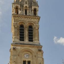
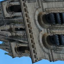
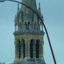
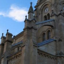
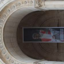
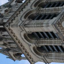
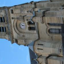
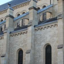
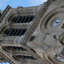
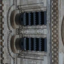
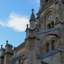
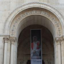
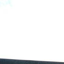
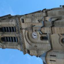
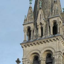
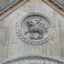
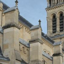
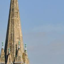
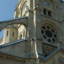
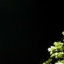
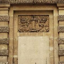
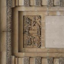
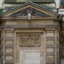
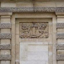
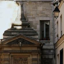
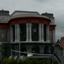
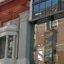
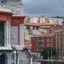
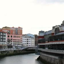

In [69]:
# load validation image in memory
x_test = []
for p in tqdm(x_test_p):
    img = tf.io.read_file(p)
    img =  tf.io.decode_image(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)
    x_test.append(img)

# print some of the val images
ipyplot.plot_images(x_test, y_test, img_width=64)

In [122]:
IMG_PER_CLASS = 1
index = defaultdict(list)
x_index = []
y_index = []
x_query = []
y_query = []
for idx in range(len(x_test)):
    cidx = testlmk2id[y_test[idx]]
    if len(index[cidx]) < IMG_PER_CLASS:
        index[cidx].append(x_test[idx])
        x_index.append(x_test[idx])
        y_index.append(cidx)        
    else:
        x_query.append(x_test[idx])
        y_query.append(cidx)

x_index = np.array(x_index)
y_index = np.array(y_index)
x_query = np.array(x_query)
y_query = np.array(y_query)



## prepare training

In [66]:
# read each image from disk and construct the batch as "augment function" to 
# sampler
@tf.function()
def process(p):
    augmenter = RandAugment()
    #img = tf.io.read_file(p)
    img = tf.io.decode_image(p)
    if tf.shape(img)[0] < IMG_SIZE or tf.shape(img)[1] < IMG_SIZE:
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)
    img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
    img = augmenter.distort(img)
    return img

def loader(x, y, sample_per_batch, is_warmup):

    imgs = []
    for p in x:
       imgs.append(tf.io.read_file(p))
    imgs = tf.stack(imgs)
    imgs = tf.map_fn(process, 
                     imgs, 
                     parallel_iterations=CPU_COUNT,
                     dtype='uint8')
    # return tf.stack(imgs, axis=0), tf.constant(y)
    return imgs, y
print(loader(x[:16], y[:16], None, None)[0].shape)

(16, 224, 224, 3)


In [67]:
print("Build train sampler")
train_ds = MultiShotMemorySampler(x_train, y_train,
                                 classes_per_batch=CLASSES_PER_BATCH,
                                 augmenter=loader)

Build train sampler

Batch size is 32 -> 16 class * 2 examples * (1 + 0 augmentations)


indexing classes: 100%|██████████| 1577570/1577570 [00:01<00:00, 1138219.33it/s]



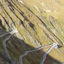
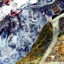
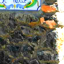
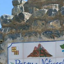
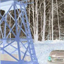
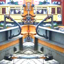
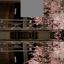
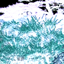
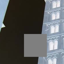
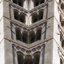
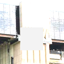
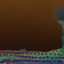
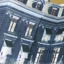
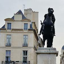
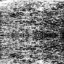
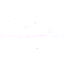
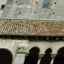
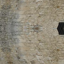
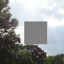
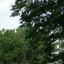
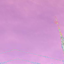
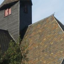
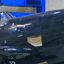
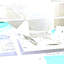
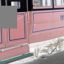
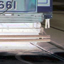
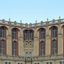
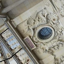
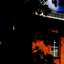
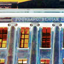


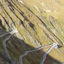
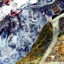
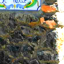
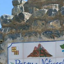
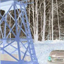
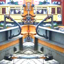
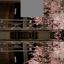
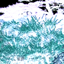
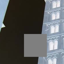
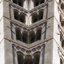
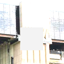
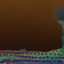
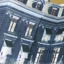
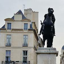
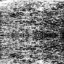
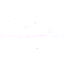
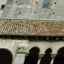
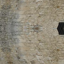
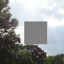
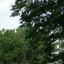
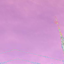
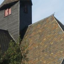
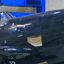
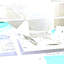
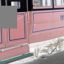
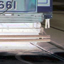
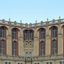
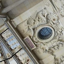
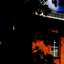
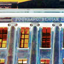

In [72]:
x_batch, y_batch = train_ds.generate_batch(1)
ipyplot.plot_images(x_batch, y_batch, img_width=64)

In [13]:
embedding_size = 256
model = EfficientNetSim((IMG_SIZE, IMG_SIZE, 3), embedding_size=embedding_size, augmentation=None)
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
metric_embedding (MetricEmbe (None, 256)               327936    
Total params: 4,377,507
Trainable params: 327,936
Non-trainable params: 4,049,571
_________________________________________________________________


In [15]:
epochs = 10
loss = MultiSimilarityLoss(distance='cosine')
model.compile('adam', loss=loss)
history = model.fit(train_ds, epochs=10, validation_data=(x_test, y_test))

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/10
1000/1000 [==============================] - 359s 351ms/step - loss: 1.0219 - val_loss: 1.0110
Warmup complete
Epoch 2/10
1000/1000 [==============================] - 328s 328ms/step - loss: 1.0051 - val_loss: 1.0030
Epoch 3/10
1000/1000 [==============================] - 287s 286ms/step - loss: 1.0000 - val_loss: 0.9896
Epoch 4/10
1000/1000 [==============================] - 280s 280ms/step - loss: 0.9979 - val_loss: 0.9856
Epoch 5/10
1000/1000 [==============================] - 277s 277ms/step - loss: 0.9970 - val_loss: 0.9880
Epoch 6/10
1000/1000 [==============================] - 277s 277ms/step - loss: 0.9926 - val_loss: 0.9920
Epoch 7/10
1000/1000 [==============================] - 272s 272ms/step - loss: 0.9938 - val_loss: 0.9795
Epoch 8/10
1000/1000 [==============================] - 267s 267ms/step - loss: 0.9912 - val_loss: 0.9893
Epoch 9/10
1000/1000 [==============================] - 26

In [16]:
model.save("models/kaggle/")

INFO:tensorflow:Assets written to: models/kaggle/assets


INFO:tensorflow:Assets written to: models/kaggle/assets
C:\Users\elie\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [73]:
model = tf.keras.models.load_model("models/kaggle/")

Distance metric automatically set to cosine use the distance arg to override.


In [123]:
model.reset_index()
model.index(x=x_index, y=y_index, data=x_index)

[Indexing 120 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


In [124]:
calibration = model.calibrate(x_query, y_query)

computing thresholds: 100%|██████████| 2778/2778 [00:00<00:00, 150157.56it/s]


Performing NN search


 name       value    distance    precision    recall        f1
-------  -------  ----------  -----------  --------  --------
optimal      0.5    0.160935     0.334653         1  0.501483


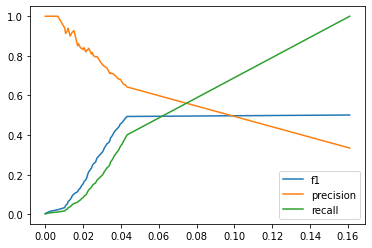

In [126]:
fig, ax = plt.subplots()
x = calibration.thresholds['distance']
ax.plot(x, calibration.thresholds['f1'], label='f1')
ax.plot(x, calibration.thresholds['precision'], label='precision')
ax.plot(x, calibration.thresholds['recall'], label='recall')
ax.legend()
plt.show()

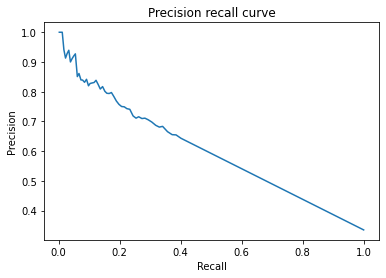

In [127]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds['recall'], calibration.thresholds['precision'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

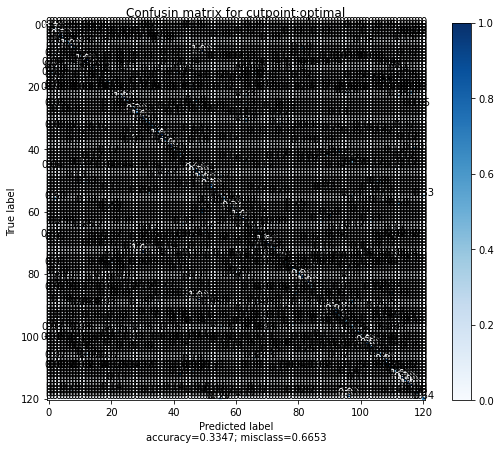

In [128]:
cutpoint = 'optimal'
matches = model.match(x_query, cutpoint=cutpoint)
confusion_matrix(matches, y_query, title='Confusin matrix for cutpoint:%s' % cutpoint)